In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize
from scipy.optimize import nnls

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [2]:
nf, r_in, r_out = (3, 1, 2)
organo3 = create_organo(nf, r_in, r_out)
print(organo3.vert_df.loc[:, ('x', 'y')])

organo3.edge_df.loc[organo3.apical_edges, 'line_tension'] *= 2
organo3.edge_df.loc[organo3.basal_edges, 'line_tension'] = 0
geom.update_all(organo3)
res = Solver.find_energy_min(organo3, geom, model)

Reseting datasets values with new specs


             x             y
vert                        
0     0.277926 -4.813825e-01
1    -0.555853  6.807231e-17
2     0.277926  4.813825e-01
3     0.555853 -9.627649e-01
4    -1.111705  1.361446e-16
5     0.555853  9.627649e-01


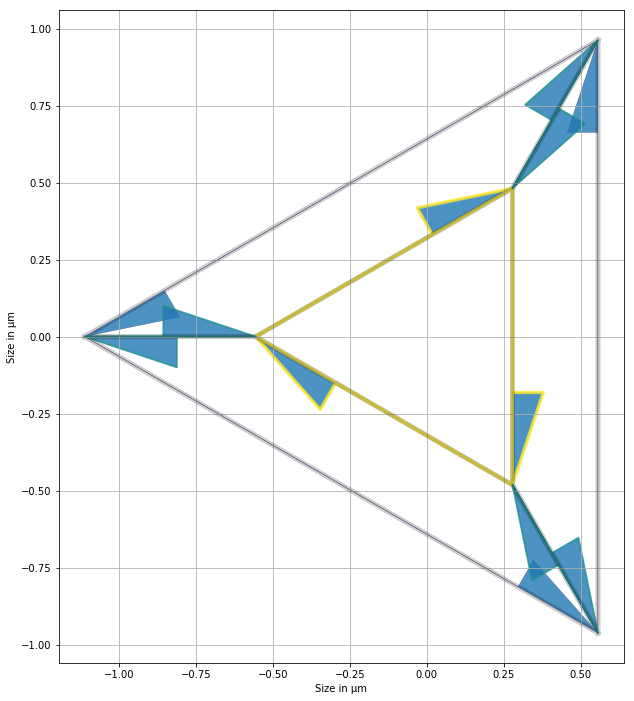

In [3]:
print_tensions(organo3, organo3)

In [4]:
real_data = np.concatenate((organo3.edge_df.line_tension[:3*organo3.Nf],
                            organo3.face_df.prefered_area - organo3.face_df.area,
                            [organo3.settings['lumen_prefered_vol']-
                             organo3.settings['lumen_volume']]))
print(organo3.edge_df.line_tension, '\n',
      organo3.face_df.prefered_area - organo3.face_df.area)

edge
0     0.002
1     0.002
2     0.002
3     0.000
4     0.000
5     0.000
6     0.001
7     0.001
8     0.001
9     0.001
10    0.001
11    0.001
Name: line_tension, dtype: float64 
 face
0    0.0
1    0.0
2    0.0
dtype: float64


Computing the rank of $A$, we can see that the linear equations system has infinitely many solutions

In [5]:
print('Rank of A: ',
      np.linalg.matrix_rank(_coef_matrix(organo3, sup_param='areas')),
      '\nDimension of A: ',
      _coef_matrix(organo3, sup_param='areas').shape[0])

Rank of A:  9 
Dimension of A:  13


## Les lignes de A ne sont pas indépendantes

Il est possible d'exprimer les lignes 0 et 6 comme des combinaisons linéaires des lignes 1 à 5 et 7 à 11, respectivement.

In [6]:
matrix = _coef_matrix(organo3, sup_param='areas')
matrix[1]+matrix[2]+matrix[3]+matrix[4]+matrix[5]

array([ 8.66025404e-01,  0.00000000e+00, -4.61264420e-16,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -5.00000000e-01,  0.00000000e+00,
        0.00000000e+00, -4.81382468e-01,  0.00000000e+00,  7.22073702e-01,
       -4.81382468e-02])

In [7]:
-matrix[0]

array([ 8.66025404e-01, -0.00000000e+00, -4.61264420e-16, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -5.00000000e-01, -0.00000000e+00,
       -0.00000000e+00, -4.81382468e-01, -0.00000000e+00,  7.22073702e-01,
       -4.81382468e-02])

In [8]:
matrix[7]+matrix[8]+matrix[9]+matrix[10]+matrix[11]

array([-0.5       ,  0.        , -1.        ,  0.        ,  0.        ,
        0.        ,  0.8660254 ,  0.        ,  0.        , -0.5558526 ,
        0.        ,  0.13896315,  0.08337789])

In [9]:
-matrix[6]

array([-0.5       , -0.        , -1.        , -0.        , -0.        ,
       -0.        ,  0.8660254 , -0.        , -0.        , -0.5558526 ,
       -0.        ,  0.13896315,  0.08337789])

## Matrice sans modification

Apical tensions:  [0.00106156 0.00106156 0.        ] 
Basal tensions:  [0.         0.         0.00084925] 
Lateral tensions:  [0.00257415 0.00367736 0.00257415] 
Area elasticity:  [0.00381958 0.00381958 0.00305566] 
Lumen area elasticity:  0.0 
Distance to solution:  0.007557920068884367 
NNLS residuals:  1.6748341148895201e-18


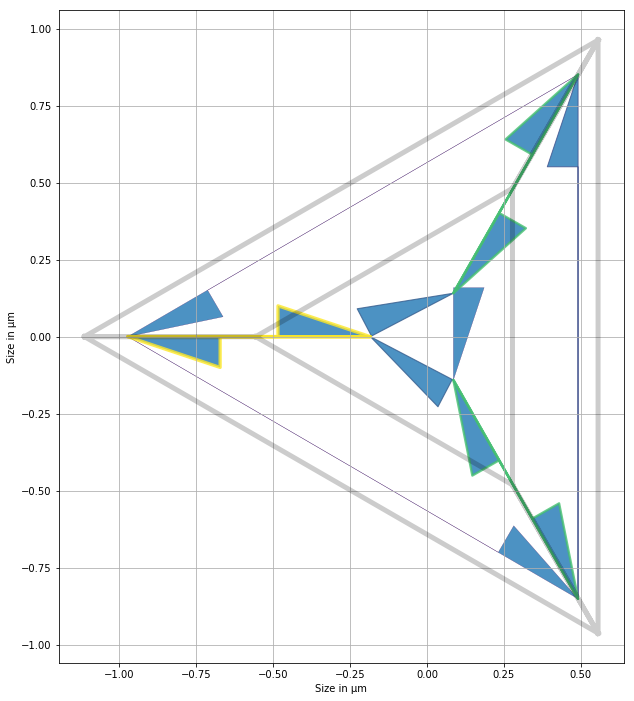

In [10]:
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
no_mod_mat, residuals = nnls(matrix, constant)
organo3_no_mod_mat = organo3.copy()
organo3_no_mod_mat.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_no_mod_mat,
                                                                     no_mod_mat[:3*organo3.Nf])
organo3_no_mod_mat.face_df.loc[:, 'prefered_area'] = organo3_no_mod_mat.face_df.area + no_mod_mat[3*organo3.Nf:
                                                                                                  4*organo3.Nf]
organo3_no_mod_mat.settings['lumen_prefered_vol'] = no_mod_mat[-1]
Solver.find_energy_min(organo3_no_mod_mat, geom, model)
print_tensions(organo3_no_mod_mat, organo3)
print('Apical tensions: ', no_mod_mat[organo3.apical_edges],
      '\nBasal tensions: ', no_mod_mat[organo3.basal_edges],
      '\nLateral tensions: ', no_mod_mat[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', no_mod_mat[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', no_mod_mat[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-no_mod_mat),
      '\nNNLS residuals: ', residuals)

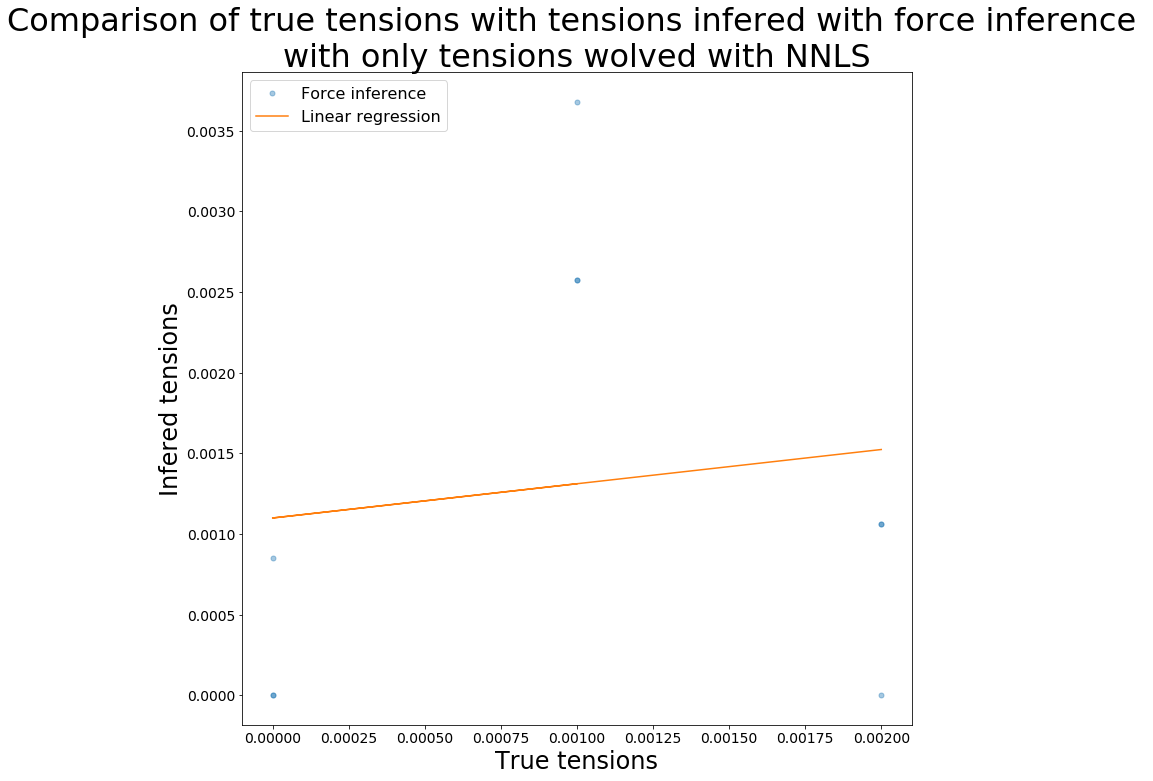

R value : 0.13759967547978905 
Standard error : 0.0010806672429354673


In [11]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  no_mod_mat[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Matrice avec le bon facteur d'échelle

Apical tensions:  [0.0008098 0.0008098 0.       ] 
Basal tensions:  [0.         0.         0.00064784] 
Lateral tensions:  [0.00196366 0.00280523 0.00196366] 
Area elasticity:  [0.00291373 0.00291373 0.00233098] 
Lumen area elasticity:  0.0 
Distance to solution:  0.005897631480301053 
NNLS residuals:  1.566299283139904e-18


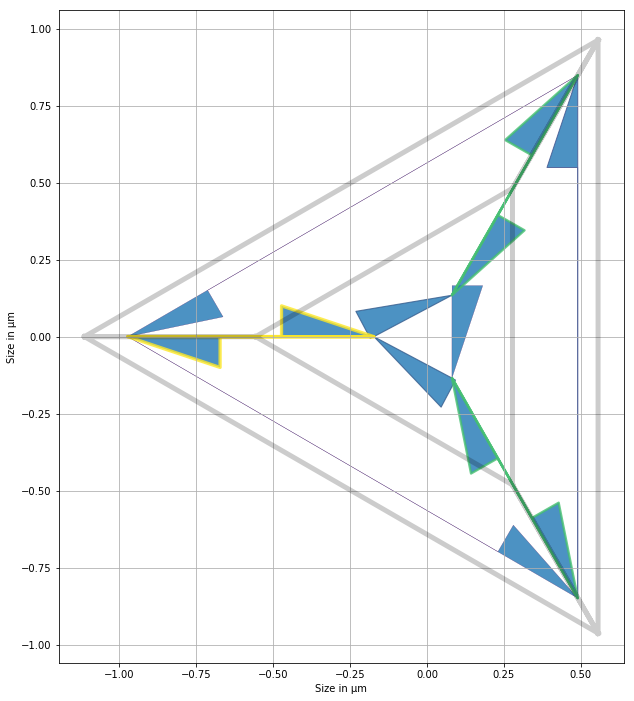

In [12]:
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
constant[-1] = 0.009
mat_right_fact, residuals = nnls(matrix, constant)
organo3_right_fact = organo3.copy()
organo3_right_fact.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_right_fact,
                                                                     mat_right_fact[:3*organo3.Nf])
organo3_right_fact.face_df.loc[:, 'prefered_area'] = organo3_right_fact.face_df.area + mat_right_fact[3*organo3.Nf:
                                                                                                  4*organo3.Nf]
organo3_right_fact.settings['lumen_prefered_vol'] = mat_right_fact[-1]
Solver.find_energy_min(organo3_right_fact, geom, model)
print_tensions(organo3_right_fact, organo3)
print('Apical tensions: ', mat_right_fact[organo3.apical_edges],
      '\nBasal tensions: ', mat_right_fact[organo3.basal_edges],
      '\nLateral tensions: ', mat_right_fact[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_right_fact[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_right_fact[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_right_fact),
      '\nNNLS residuals: ', residuals)

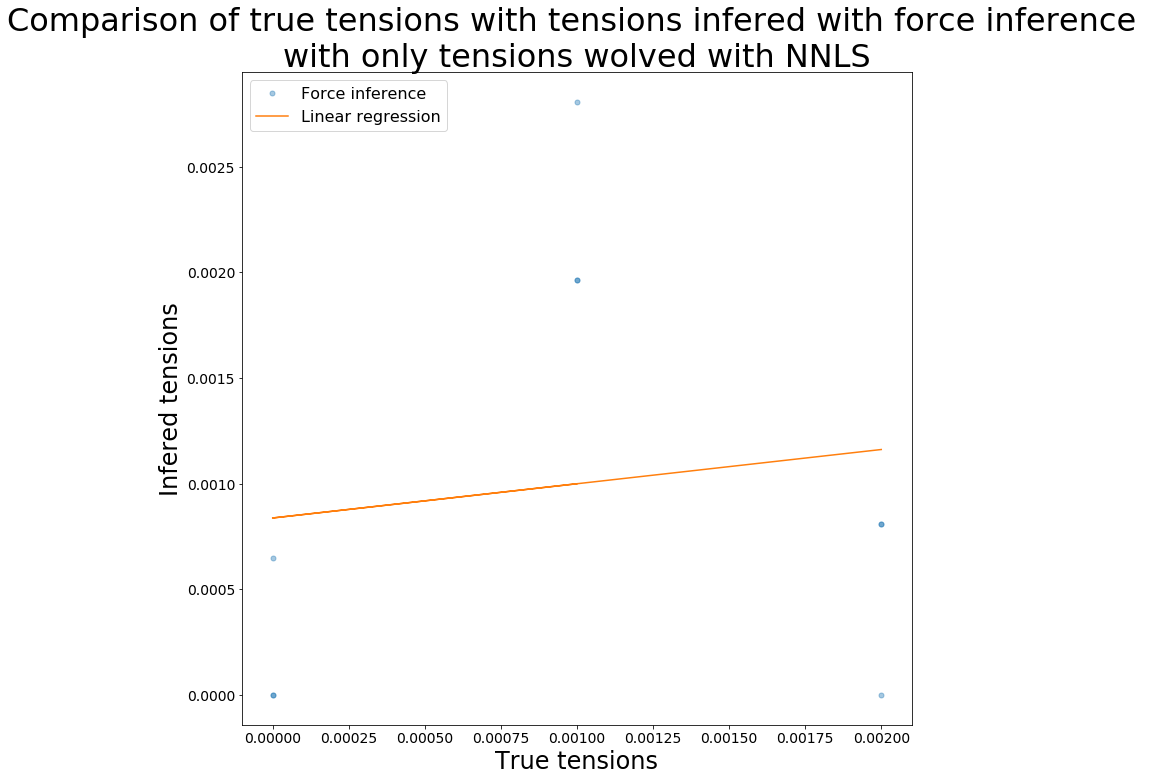

R value : 0.13759967547978877 
Standard error : 0.0008243753387393954


In [13]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_right_fact[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Matrice avec une contrainte sur le rapport des moyennes des tensions

Apical tensions:  [0.00225 0.00225 0.00225] 
Basal tensions:  [0. 0. 0.] 
Lateral tensions:  [0.00075 0.00075 0.00075] 
Area elasticity:  [0.00077901 0.00077901 0.00077901] 
Lumen area elasticity:  0.03658332562299425 
Distance to solution:  0.03661332088629032 
NNLS residuals:  5.5001600320485475e-19


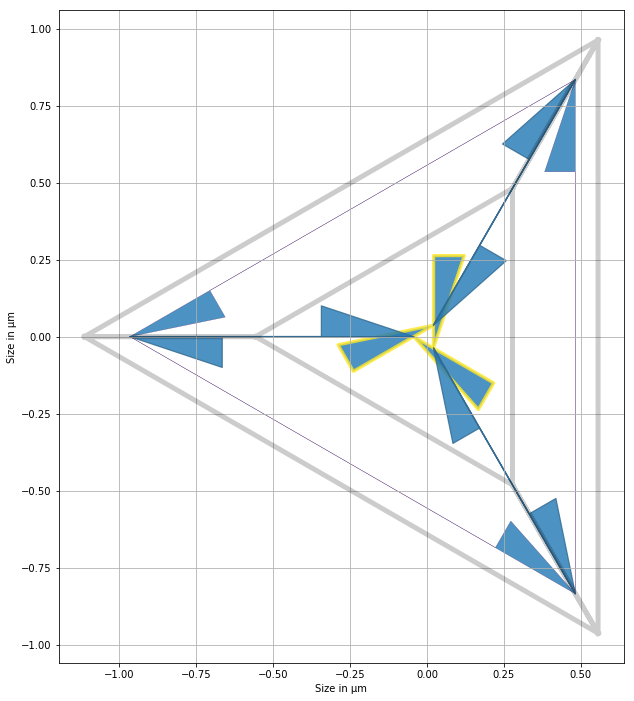

In [14]:
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
constant[-1] = 0.009
avg_line1 = [1, 1, 1, 0, 0, 0, -3, -3, -3, 0, 0, 0, 0]
avg_cste = [0]
matrix = np.vstack((matrix, avg_line1))
constant = np.concatenate((constant, avg_cste))
mat_mean_cst, residuals = nnls(matrix, constant)
organo3_mean_cst = organo3.copy()
organo3_mean_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_mean_cst,
                                                                   mat_mean_cst[:3*organo3.Nf])
organo3_mean_cst.face_df.loc[:, 'prefered_area'] = organo3_mean_cst.face_df.area + mat_mean_cst[3*organo3.Nf:
                                                                                              4*organo3.Nf]
organo3_mean_cst.settings['lumen_prefered_vol'] = mat_mean_cst[-1]
Solver.find_energy_min(organo3_mean_cst, geom, model)
print_tensions(organo3_mean_cst, organo3)
print('Apical tensions: ', mat_mean_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_mean_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_mean_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_mean_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_mean_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_mean_cst),
      '\nNNLS residuals: ', residuals)

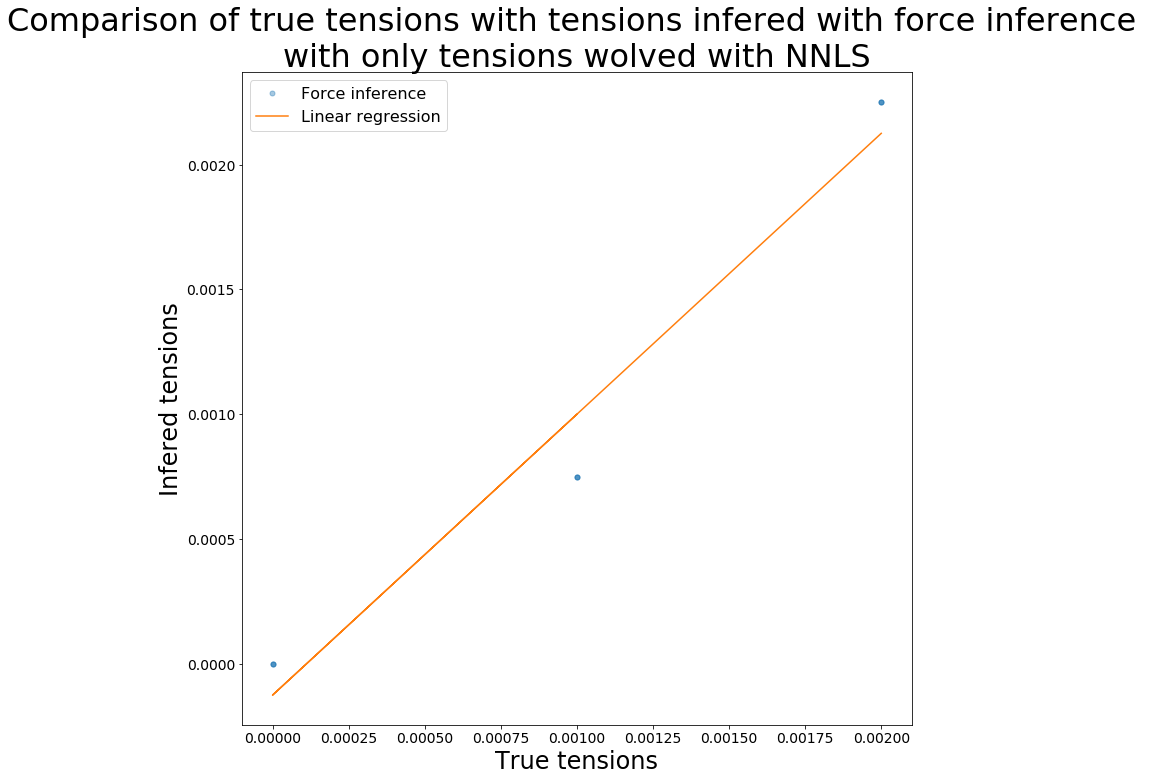

R value : 0.9819805060619659 
Standard error : 0.0001530931089239486


In [15]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_mean_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Matrice avec la dernière ligne "splitée" en trois contraintes
On supprime la contrainte $$\sum \Lambda_{i,j} = c$$ On ajoute les contraintes $$\Lambda_0 + \Lambda_1 + \Lambda_2 = c_1$$ $$\Lambda_3 + \Lambda_4 + \Lambda_5 = c_2$$ $$\Lambda_6 + \Lambda_7 + \Lambda_8 = c_3$$ Où $c_1+c_2+c_3=c$

Apical tensions:  [0.002 0.002 0.002] 
Basal tensions:  [0. 0. 0.] 
Lateral tensions:  [0.001 0.001 0.001] 
Area elasticity:  [0.00103868 0.00103868 0.00103868] 
Lumen area elasticity:  0.0307873864405591 
Distance to solution:  0.030839904376408045 
NNLS residuals:  9.606895934580462e-19


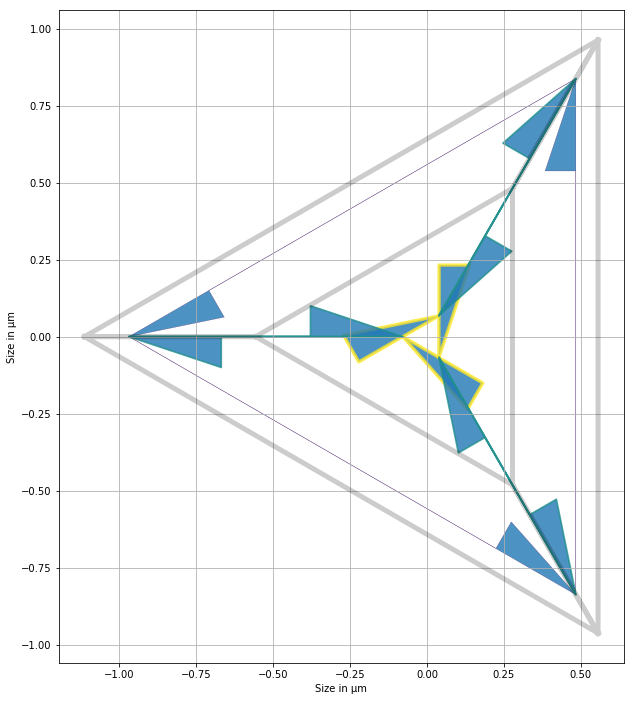

In [16]:
from scipy.optimize import nnls
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
constant[-1] = 0.006
constant = np.concatenate((constant, [0, 0.003]))
matrix = _coef_matrix(organo3, sup_param='areas')
matrix[-1] = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
matrix = np.vstack((matrix,
                    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]))
mat_3_cst, residuals = nnls(matrix, constant)
organo3_mat_3_cst = organo3.copy()
organo3_mat_3_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_mat_3_cst,
                                                                    mat_3_cst[:3*organo3.Nf])
organo3_mat_3_cst.face_df.loc[:, 'prefered_area'] = organo3_mat_3_cst.face_df.area + mat_3_cst[3*organo3.Nf:
                                                                                                4*organo3.Nf]
organo3_mat_3_cst.settings['lumen_prefered_vol'] = mat_3_cst[-1]
Solver.find_energy_min(organo3_mat_3_cst, geom, model)
print_tensions(organo3_mat_3_cst, organo3)
print('Apical tensions: ', mat_3_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_3_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_3_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_3_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_3_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_3_cst),
      '\nNNLS residuals: ', residuals)

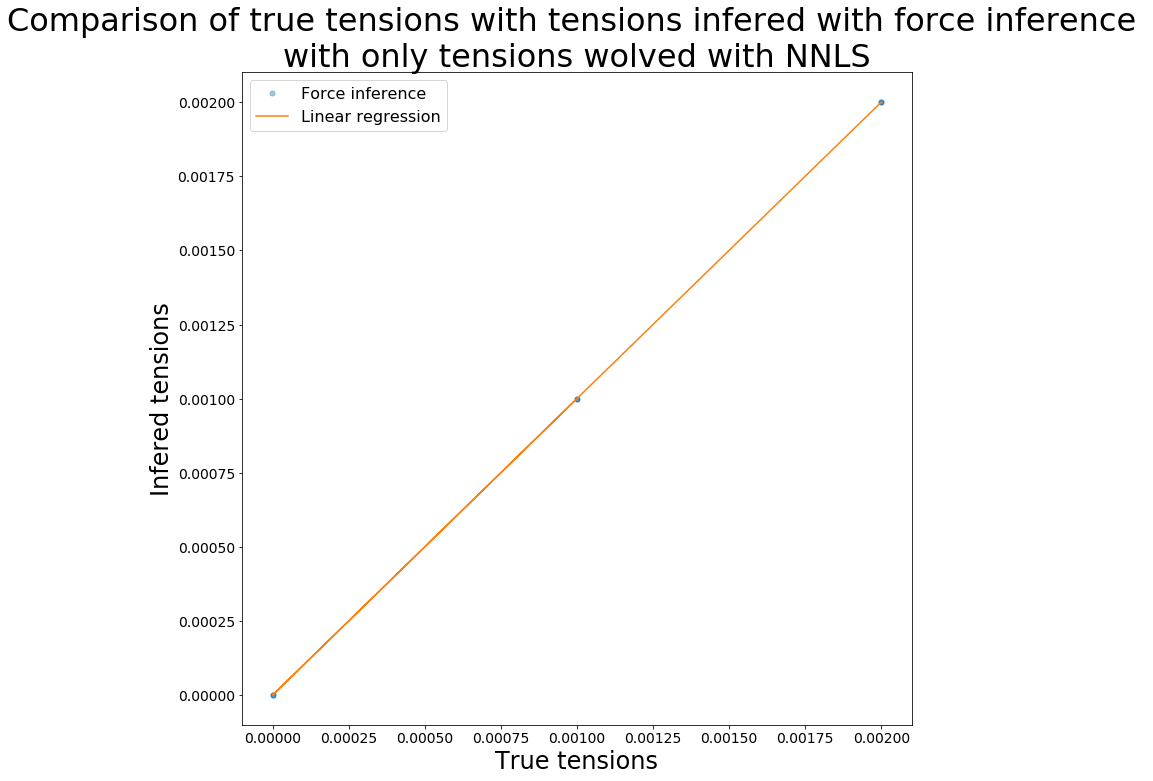

R value : 1.0 
Standard error : 6.654093017156645e-19


In [17]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_3_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Matrice avec la dernière ligne "splitée" en deux contraintes
On constate qu'il suffit d'ajouter deux contraintes pour obtenir le résultat attendu.

Apical tensions:  [0.002 0.002 0.002] 
Basal tensions:  [3.77569963e-19 1.47448659e-19 0.00000000e+00] 
Lateral tensions:  [0. 0. 0.] 
Area elasticity:  [1.22215906e-19 2.33931461e-19 2.56365192e-19] 
Lumen area elasticity:  0.035980762113533155 
Distance to solution:  0.03602242693476738 
NNLS residuals:  4.065564799163062e-19


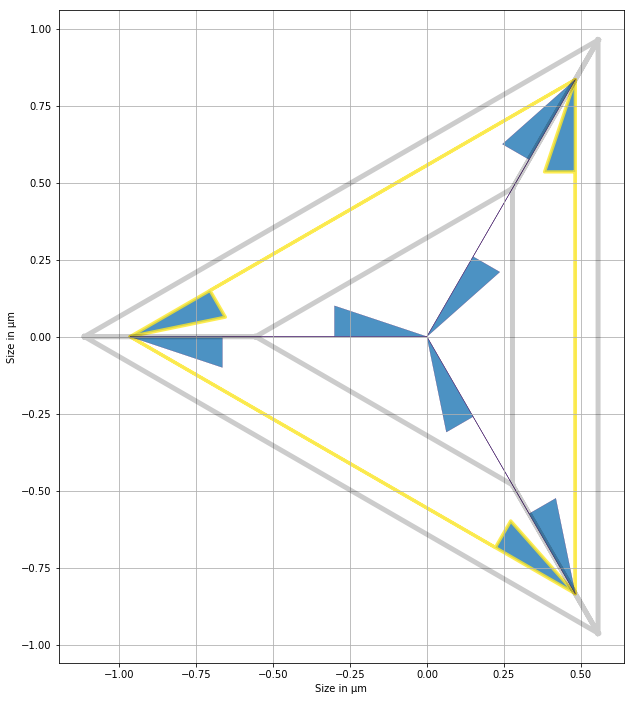

In [18]:
from scipy.optimize import nnls
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
constant[-1] = 0.006
constant = np.concatenate((constant, [0]))
matrix = _coef_matrix(organo3, sup_param='areas')
matrix[-1] = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
matrix = np.vstack((matrix,
                    [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]))
mat_2_cst, residuals = nnls(matrix, constant)
organo3_mat_2_cst = organo3.copy()
organo3_mat_2_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_mat_2_cst,
                                                                    mat_2_cst[:3*organo3.Nf])
organo3_mat_2_cst.face_df.loc[:, 'prefered_area'] = organo3_mat_2_cst.face_df.area + mat_2_cst[3*organo3.Nf:
                                                                                                4*organo3.Nf]
organo3_mat_2_cst.settings['lumen_prefered_vol'] = mat_2_cst[-1]
Solver.find_energy_min(organo3_mat_2_cst, geom, model)
print_tensions(organo3_mat_2_cst, organo3)
print('Apical tensions: ', mat_2_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_2_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_2_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_2_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_2_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_2_cst),
      '\nNNLS residuals: ', residuals)

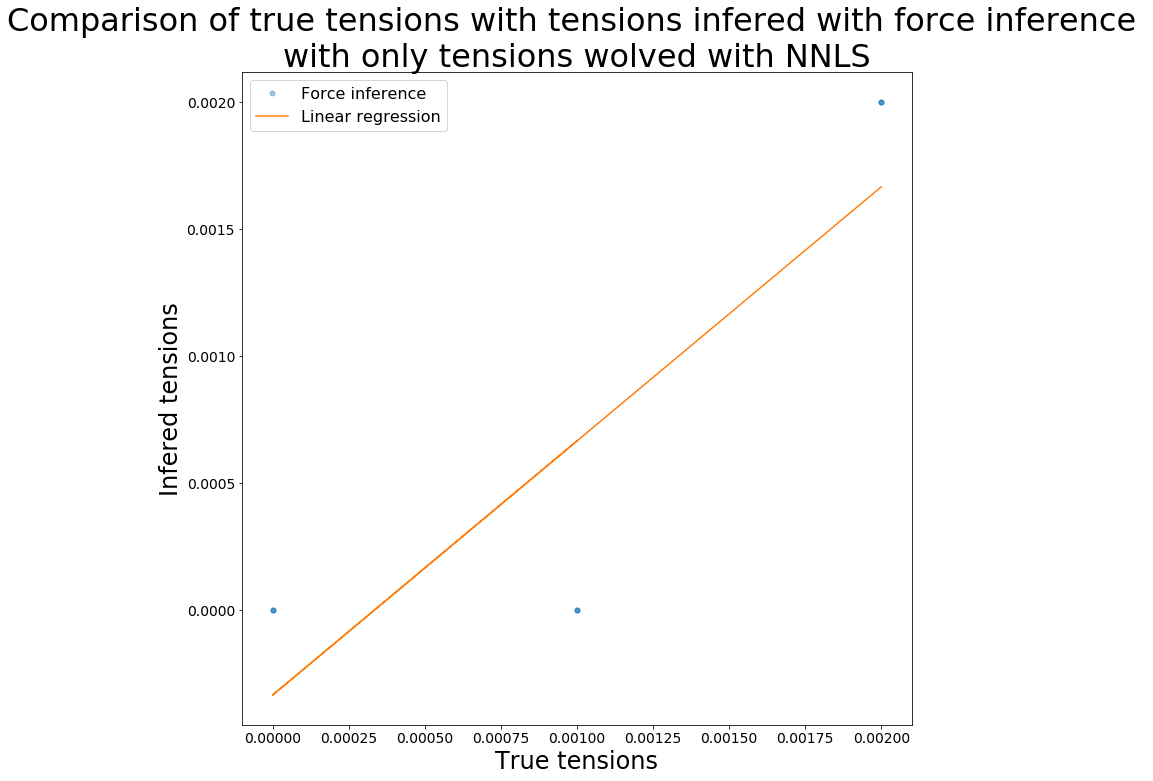

R value : 0.8660254037844386 
Standard error : 0.0004082482904638631


In [19]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_2_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Résolution pour les sommets 0 et 3

Apical tensions:  [0.00172077 0.00172077] 
Basal tensions:  [0. 0.] 
Lateral tensions:  0.0012939326521884886 
Area elasticity:  [0.00079996 0.00079996] 
Lumen area elasticity:  0.01882482921609117 
Distance to solution:  0.01886521704150443 
NNLS residuals:  0.001150060395382562


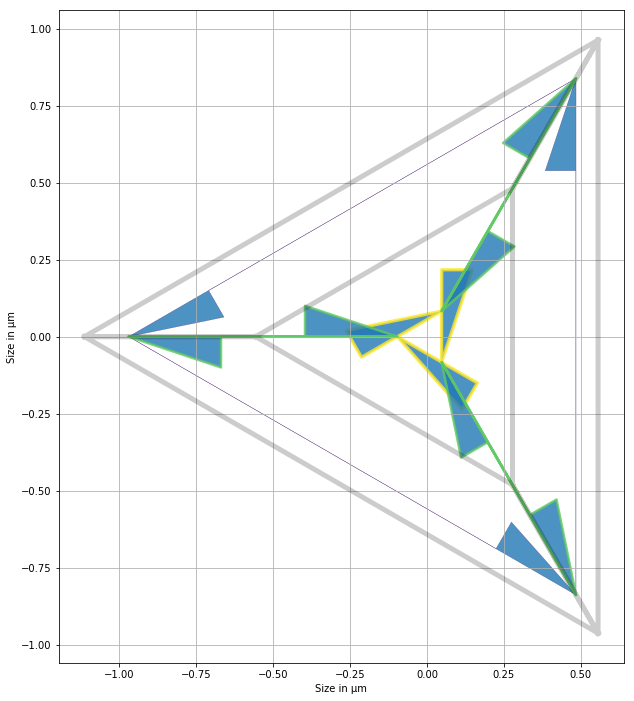

In [20]:
from scipy.optimize import nnls
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix) # [[0, 3, 6, 9, 12]]
constant[-1] = organo3.edge_df.line_tension[[0, 2, 9]].sum()
matrix = matrix[:, [0, 2, 3, 5, 6, 9, 11, 12]]
mat_vert_0_and_3, residuals = nnls(matrix, constant)
organo3_vert_0_and_3 = organo3.copy()
organo3_vert_0_and_3.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_vert_0_and_3,
                                                                       np.concatenate((np.repeat(mat_vert_0_and_3[0], 3),
                                                                                       np.repeat(mat_vert_0_and_3[2], 3),
                                                                                       np.repeat(mat_vert_0_and_3[4], 3))))
organo3_vert_0_and_3.face_df.loc[:, 'prefered_area'] = organo3_vert_0_and_3.face_df.area + np.repeat(mat_vert_0_and_3[5], 3)
organo3_vert_0_and_3.settings['lumen_prefered_vol'] = mat_vert_0_and_3[-1]
Solver.find_energy_min(organo3_vert_0_and_3, geom, model)
print_tensions(organo3_vert_0_and_3, organo3)
print('Apical tensions: ', mat_vert_0_and_3[:2],
      '\nBasal tensions: ', mat_vert_0_and_3[2:4],
      '\nLateral tensions: ', mat_vert_0_and_3[4],
      '\nArea elasticity: ', mat_vert_0_and_3[5:-1],
      '\nLumen area elasticity: ', mat_vert_0_and_3[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data[[0, 2, 3, 5, 6, 9, 11, 12]]-mat_vert_0_and_3),
      '\nNNLS residuals: ', residuals)

## Matrice avec deux contraintes d'égalité
Ici on pose les contraintes $\Lambda_1 = \Lambda_2$ et $\Lambda_6 = \Lambda_7$

Apical tensions:  [0.00067203 0.00067203 0.00067203] 
Basal tensions:  [0.00000000e+00 7.88465262e-19 0.00000000e+00] 
Lateral tensions:  [0.00232797 0.00232797 0.00232797] 
Area elasticity:  [0.00241801 0.00241801 0.00241801] 
Lumen area elasticity:  0.0 
Distance to solution:  0.005302955297071124 
NNLS residuals:  1.5354533045537508e-18


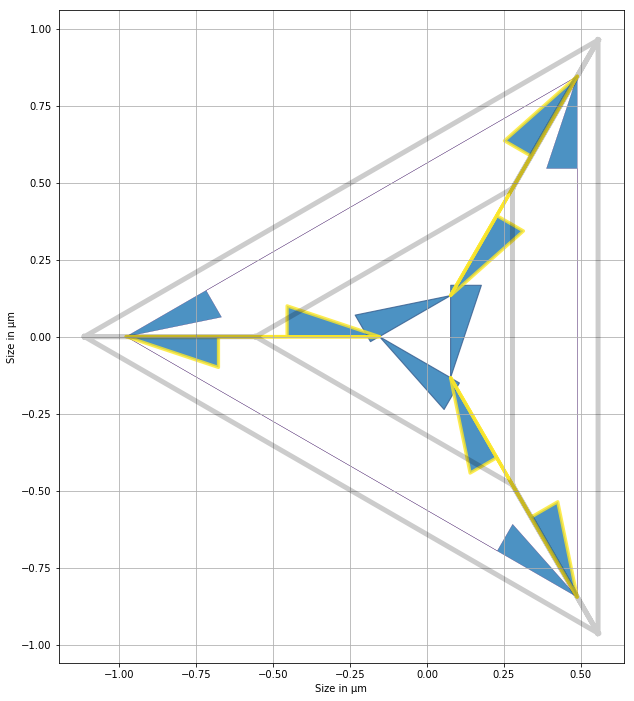

In [21]:
from scipy.optimize import nnls
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
constant[-1] = 0.009
constant = np.concatenate((constant, [0, 0]))
matrix = np.vstack((matrix,
                    [0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0]))
mat_eq_cst, residuals = nnls(matrix, constant)
organo3_eq_cst = organo3.copy()
organo3_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_eq_cst,
                                                                 mat_eq_cst[:3*organo3.Nf])
organo3_eq_cst.face_df.loc[:, 'prefered_area'] = organo3_eq_cst.face_df.area + mat_eq_cst[3*organo3.Nf:
                                                                                          4*organo3.Nf]
organo3_eq_cst.settings['lumen_prefered_vol'] = mat_eq_cst[-1]
Solver.find_energy_min(organo3_eq_cst, geom, model)
print_tensions(organo3_eq_cst, organo3)
print('Apical tensions: ', mat_eq_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_eq_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_eq_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_eq_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_eq_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_eq_cst),
      '\nNNLS residuals: ', residuals)

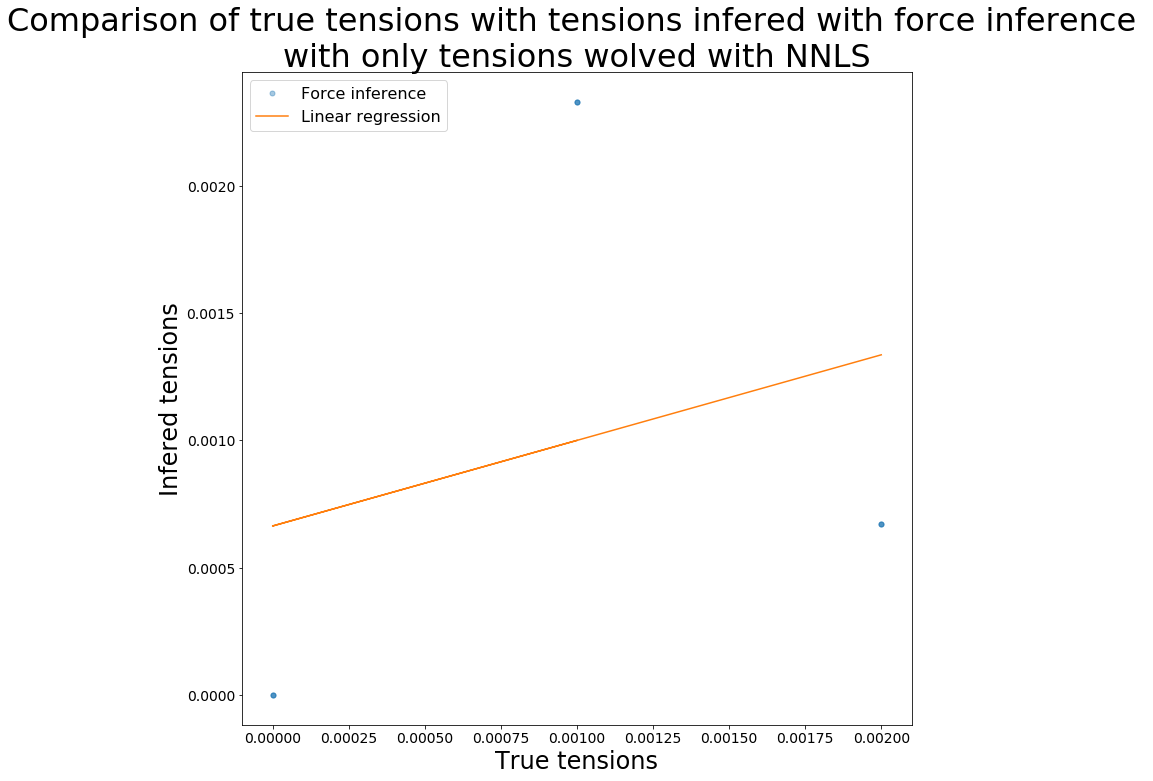

R value : 0.28044637090056074 
Standard error : 0.0008132136237923576


In [22]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_eq_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Matrice avec cst somme des élasticité = 0

Apical tensions:  [0.00111153 0.00111153 0.00111153] 
Basal tensions:  [0. 0. 0.] 
Lateral tensions:  [0.00161583 0.00161583 0.00161583] 
Area elasticity:  [0.00033827 0.00033827 0.00033827] 
Lumen area elasticity:  0.0 
Distance to solution:  0.0019619244857605623 
NNLS residuals:  0.0027131808073202687


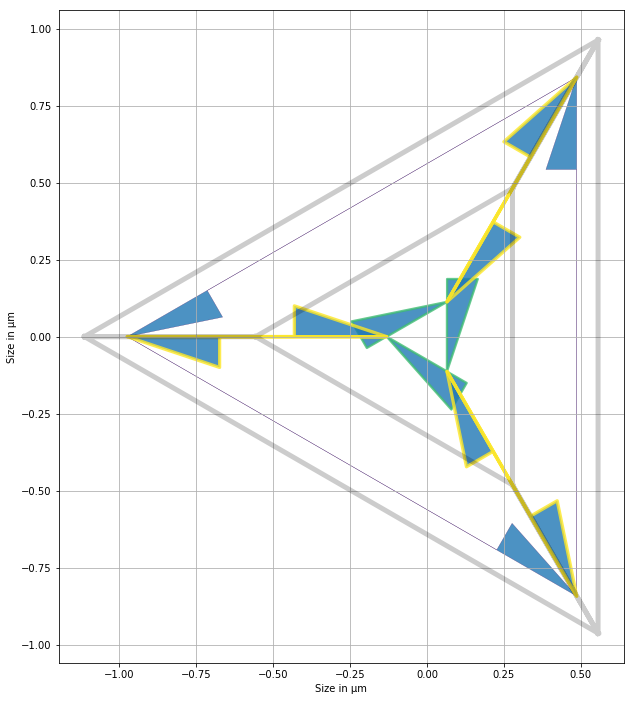

In [23]:
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
constant[-1] = 0.009
constant = np.concatenate((constant, [0]))
matrix = np.vstack((matrix,
                    np.concatenate((np.zeros(3*organo3.Nf), np.ones(organo3.Nf+1)))))
mat_eq_cst, residuals = nnls(matrix, constant)
organo3_eq_cst = organo3.copy()
organo3_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_eq_cst,
                                                                 mat_eq_cst[:3*organo3.Nf])
organo3_eq_cst.face_df.loc[:, 'prefered_area'] = organo3_eq_cst.face_df.area + mat_eq_cst[3*organo3.Nf:
                                                                                          4*organo3.Nf]
organo3_eq_cst.settings['lumen_prefered_vol'] = mat_eq_cst[-1]
Solver.find_energy_min(organo3_eq_cst, geom, model)
print_tensions(organo3_eq_cst, organo3)
print('Apical tensions: ', mat_eq_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_eq_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_eq_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_eq_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_eq_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_eq_cst),
      '\nNNLS residuals: ', residuals)

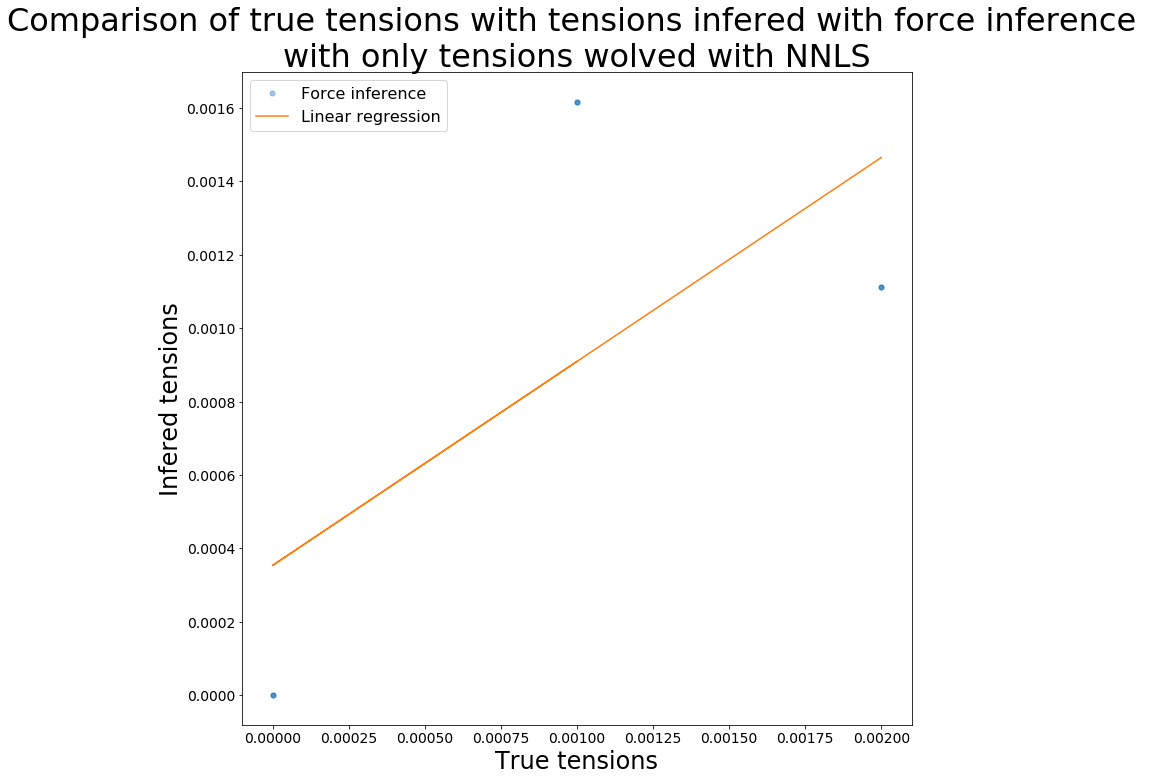

R value : 0.6722587901236795 
Standard error : 0.00043276937617795977


In [24]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_eq_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Matrice avec somme des tensions constantes dans chaque cellule

Apical tensions:  [0. 0. 0.] 
Basal tensions:  [0.03116769 0.03116769 0.03116769] 
Lateral tensions:  [0. 0. 0.] 
Area elasticity:  [0.08864227 0.08864227 0.08864227] 
Lumen area elasticity:  0.44321134428754705 
Distance to solution:  0.4721630291215278 
NNLS residuals:  0.11324747425871635


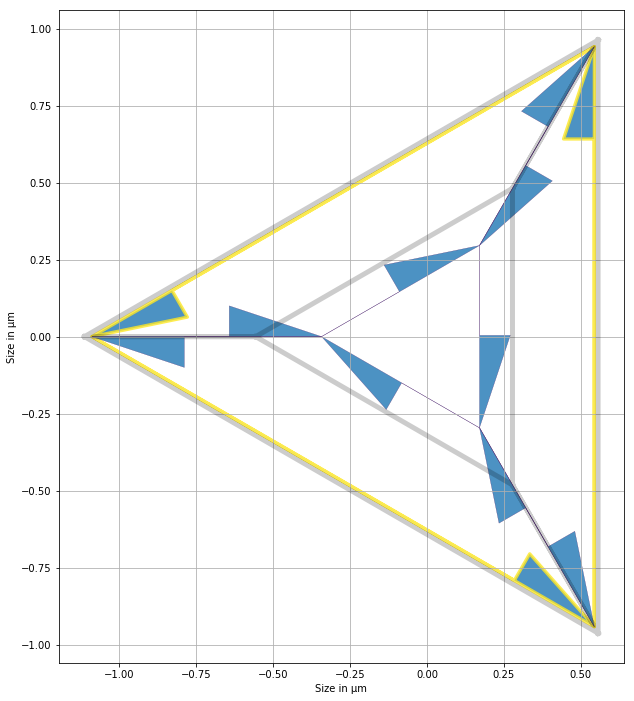

In [25]:
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
constant[-1] = 0.009
avg_cste = [0.15]*organo3.Nf
for i in range(organo3.Nf):
    i_cell_line = np.zeros(4*organo3.Nf+1)
    index = np.squeeze(np.argwhere(organo3.edge_df.face.values == i))
    i_cell_line[index] = 1
    matrix = np.vstack((matrix, i_cell_line))
constant = np.concatenate((constant, avg_cste))
mat_eq_cst, residuals = nnls(matrix, constant)
organo3_eq_cst = organo3.copy()
organo3_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_eq_cst,
                                                                 mat_eq_cst[:3*organo3.Nf])
organo3_eq_cst.face_df.loc[:, 'prefered_area'] = organo3_eq_cst.face_df.area + mat_eq_cst[3*organo3.Nf:
                                                                                          4*organo3.Nf]
organo3_eq_cst.settings['lumen_prefered_vol'] = mat_eq_cst[-1]
Solver.find_energy_min(organo3_eq_cst, geom, model)
print_tensions(organo3_eq_cst, organo3)
print('Apical tensions: ', mat_eq_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_eq_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_eq_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_eq_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_eq_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_eq_cst),
      '\nNNLS residuals: ', residuals)

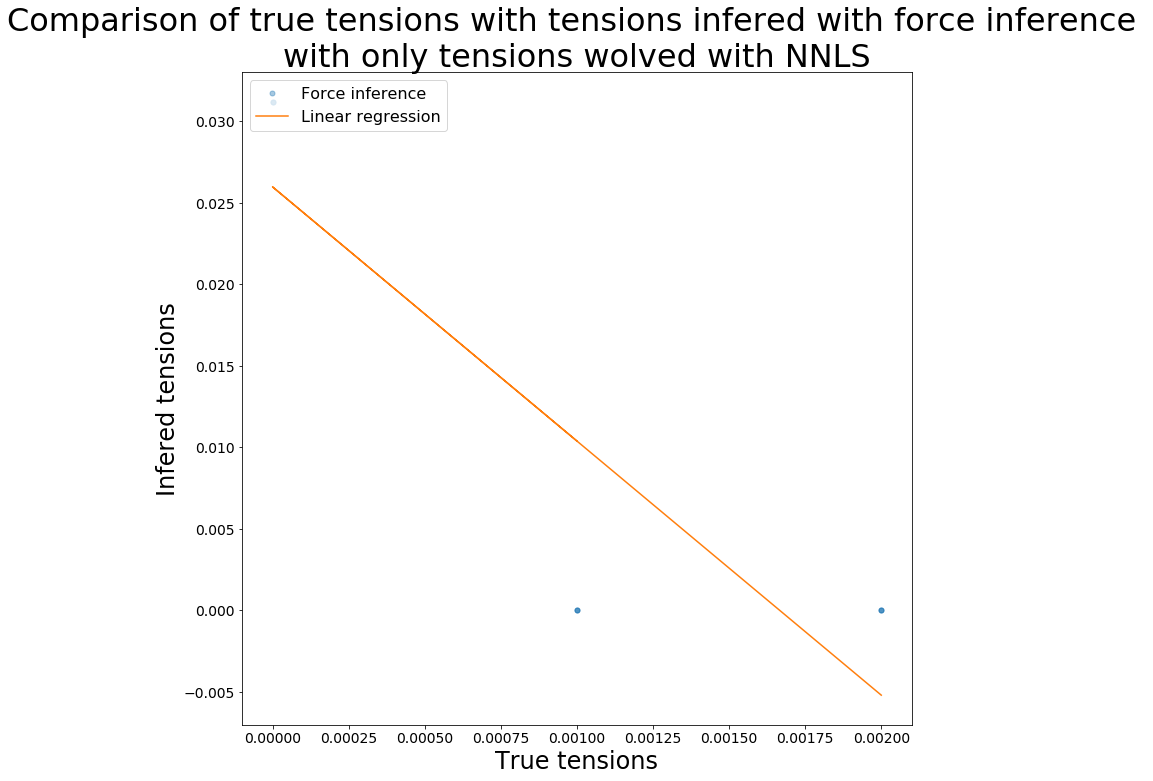

R value : -0.8660254037844389 
Standard error : 0.006362078276158062


In [26]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_eq_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Matrice avec les pressions

Apical tensions:  [0.00118301 0.00118301 0.00118301] 
Basal tensions:  [0. 0. 0.] 
Lateral tensions:  [0.0015 0.0015 0.0015] 
Area elasticity:  [2.83387543e-18 3.18518749e-19 9.08246729e-19 0.00000000e+00] 
Lumen area elasticity:  0.0 
Distance to solution:  0.0016590372918678941 
NNLS residuals:  0.0029255182530468125


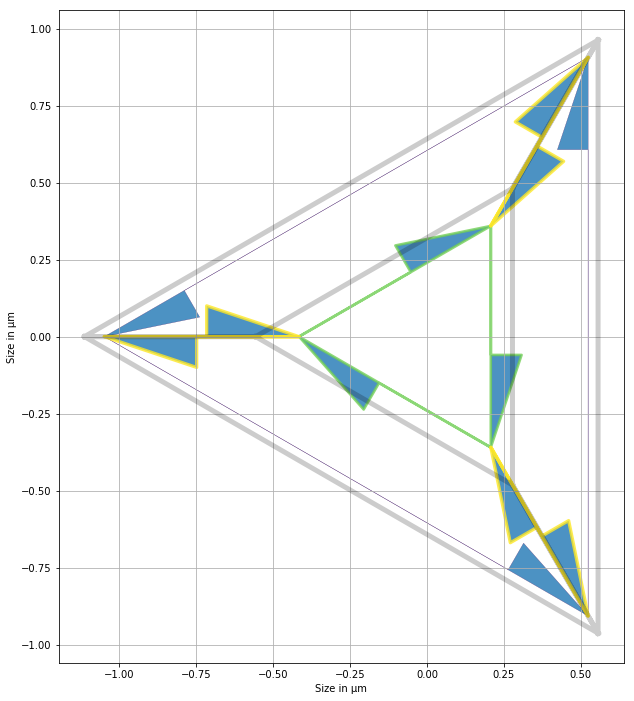

In [27]:
matrix = _coef_matrix(organo3, sup_param='pressions')
constant = _right_side(organo3, matrix)
constant[-1] = 0.009
mat_pressions, residuals = nnls(matrix, constant)
organo3_pressions = organo3.copy()
organo3_pressions.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_pressions,
                                                                    mat_pressions[:3*organo3.Nf])
Solver.find_energy_min(organo3_pressions, geom, model)
print_tensions(organo3_pressions, organo3)
print('Apical tensions: ', mat_pressions[organo3.apical_edges],
      '\nBasal tensions: ', mat_pressions[organo3.basal_edges],
      '\nLateral tensions: ', mat_pressions[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_pressions[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_pressions[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data[:organo3.Nf*3]-mat_pressions[:organo3.Nf*3]),
      '\nNNLS residuals: ', residuals)

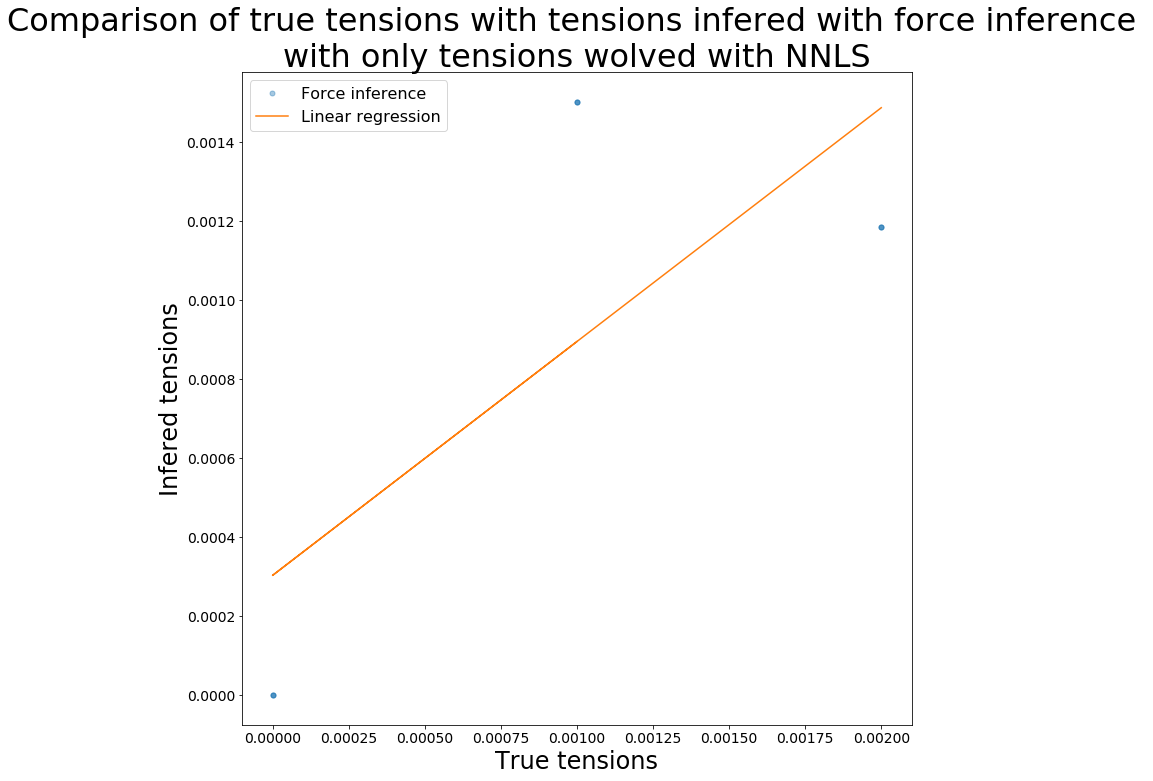

R value : 0.74820292777784 
Standard error : 0.00037089097912352745


In [28]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_pressions[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

On conserve la symétrie mais on n'obtient pas le résultat attendu.

Remarque : les relations entre les lignes de A sont conservées avec les coefficients des pressions

In [29]:
matrix[1]+matrix[2]+matrix[3]+matrix[4]+matrix[5]

array([ 8.66025404e-01,  0.00000000e+00, -4.61264420e-16,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -5.00000000e-01,  0.00000000e+00,
        0.00000000e+00, -2.40691234e-01,  0.00000000e+00,  0.00000000e+00,
        2.40691234e-01,  0.00000000e+00])

In [30]:
-matrix[0]

array([ 8.66025404e-01, -0.00000000e+00, -4.61264420e-16, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -5.00000000e-01, -0.00000000e+00,
       -0.00000000e+00, -2.40691234e-01, -0.00000000e+00, -0.00000000e+00,
        2.40691234e-01, -0.00000000e+00])

In [31]:
matrix[7]+matrix[8]+matrix[9]+matrix[10]+matrix[11]

array([-0.5       ,  0.        , -1.        ,  0.        ,  0.        ,
        0.        ,  0.8660254 ,  0.        ,  0.        , -0.13896315,
        0.        ,  0.        , -0.41688945,  0.        ])

In [32]:
-matrix[6]

array([-0.5       , -0.        , -1.        , -0.        , -0.        ,
       -0.        ,  0.8660254 , -0.        , -0.        , -0.13896315,
       -0.        , -0.        , -0.41688945, -0.        ])